First, load the data,in this notebook we are using the smokoy mountain data as the example, the input data is already the relative abundance matrix. For this analysis, we will do feature selection independently for each response variable.

In [16]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

In [17]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [18]:
df = pd.DataFrame(data,columns = ASVs)# for function later

In [19]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [20]:
yList= np.column_stack((burn_label,un_label,duration_label))# y list is a 2D array, each column is a response outcome

In [21]:
print(yList[:5])
      
for i in range(yList.shape[1]):
    print(pd.Series(yList[:,i]).value_counts())

[['No' 'Natural' 'Annual']
 ['No' 'Natural' 'Perennial']
 ['No' 'Urban' 'Perennial']
 ['No' 'Urban' 'Annual']
 ['No' 'Urban' 'Perennial']]
Yes    42
No     17
Name: count, dtype: int64
Urban      33
Natural    26
Name: count, dtype: int64
Perennial    37
Annual       22
Name: count, dtype: int64


In [22]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

In [8]:
weights=FS.OTU_H_Score_fun(data,yList)

In [9]:
weights

array([[2.33864768, 5.08900901, 7.77949148, ..., 0.4047619 , 0.4047619 ,
        0.4047619 ],
       [2.13824785, 0.86900877, 3.82466952, ..., 0.78787879, 0.78787879,
        0.78787879],
       [0.0297771 , 0.29347953, 2.82248961, ..., 1.68181818, 0.59459459,
        0.59459459]])

In [10]:
print(weights.ndim)
print(weights.shape)# each row is a H score for each response variable

2
(3, 1768)


In [11]:
#check  the H statistics
df1 = pd.DataFrame(weights, index=['burn_label', 'un_label', 'duration_label'])
columns_sig = (df1 > 2.705543454095404).any()
# Count the number of columns where at least one value is larger than 0
count = columns_sig.sum()
print(count)
count_larger= (df1 > 2.705543454095404).sum(axis=1)

# Display the result
print("Number of values larger than significance cutoff in each row:")
print(count_larger)

203
Number of values larger than significance cutoff in each row:
burn_label        141
un_label           79
duration_label     26
dtype: int64


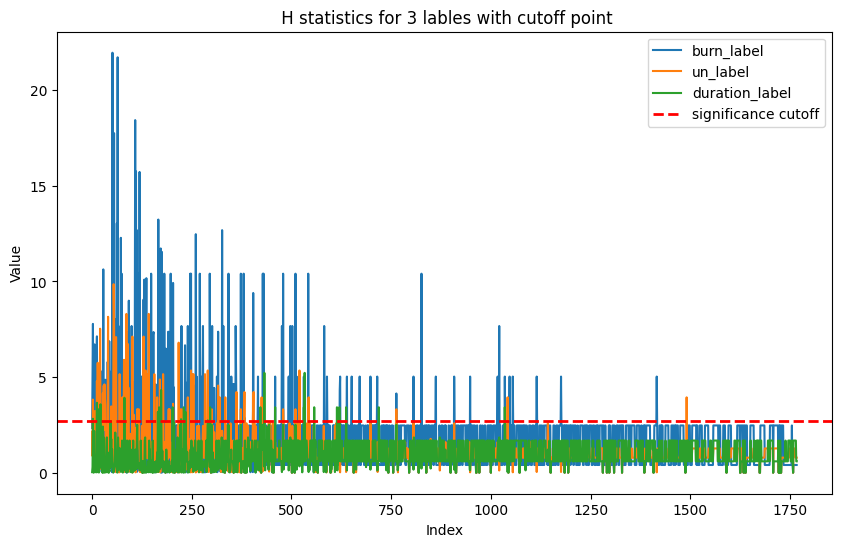

In [12]:
import matplotlib.pyplot as plt
# Plotting each row individually
# Plotting each row individually
plt.figure(figsize=(10, 6))
for row in df1.index:
    plt.plot(df1.columns, df1.loc[row], label=row)

# Add a horizontal line at y=0
plt.axhline(y=2.705543454095404, color='red', linestyle='--', linewidth=2, label='significance cutoff')

# Set plot title and labels
plt.title(' H statistics for 3 lables with cutoff point')
plt.xlabel('Index')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show the plot
plt.show()

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

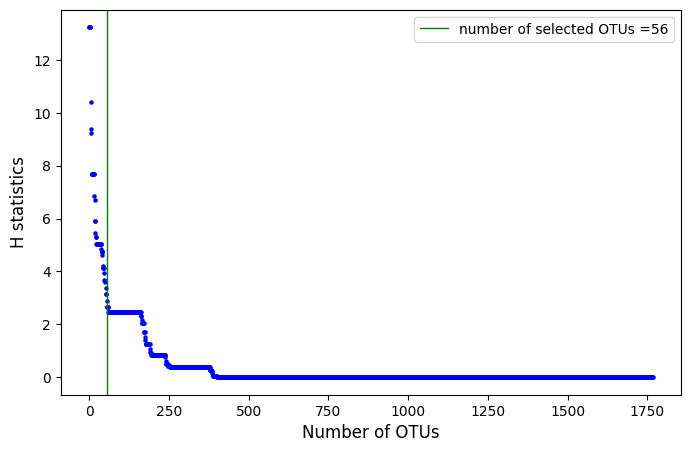

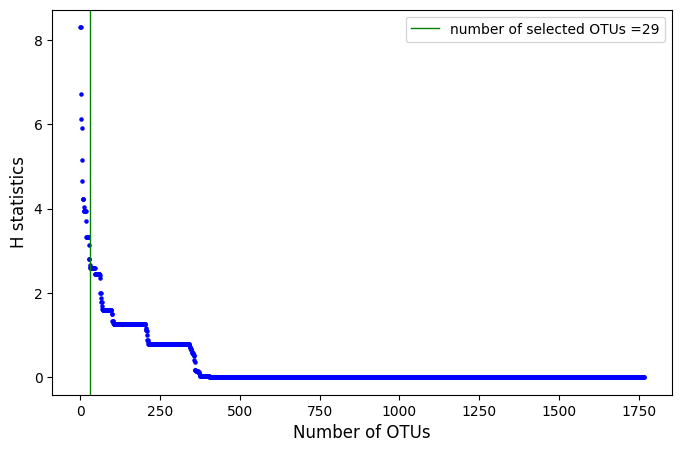

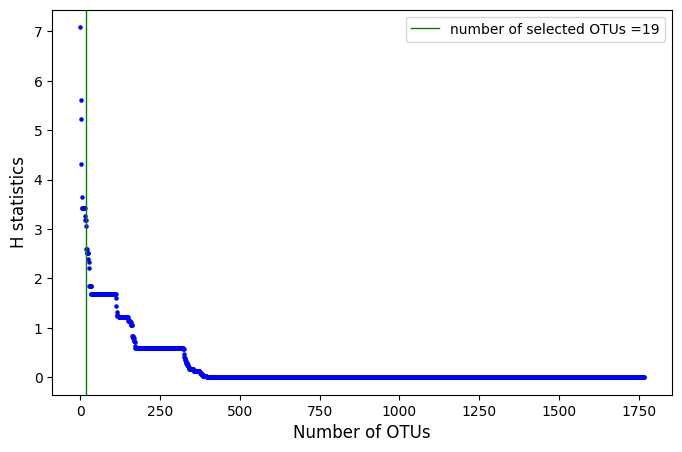

In [23]:
# select the OTUs
selected_list = []
for i in range(yList.shape[1]):
    selectedresult=FS.SelectMicro_fun(df,yList[:,i])
    selected_list.append(selectedresult)
selected_list[0].keys()

In [24]:
selectedOTU_index_list = [item['selected_indices'] for item in selected_list]
data = selected_list[0]['relative_abundance_data']

### 4. Model (default RF or SVM) 
The SVM model is always predicting one class, consider to fine tune the model's parameters.

In [25]:
iter =30
cls = ["RF","SVM"]

In [26]:
X_lasso_list = []
X_lassoft_list =[]
selectedOTU_index_lasso_list = []
selectedOTU_index_lassoft_list = []

dict_cm_list = []

for i in range(yList.shape[1]):
    targetLabel=yList[:,i]
    print("The response variable and its counts are:")
    print(pd.Series(yList[:,i]).value_counts())
    
    X_FS = selected_list[i]['selected_data']
    
    X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
    X_lasso_list.append(X_lasso)
    selectedOTU_index_lasso_list.append(xlabel_lasso)

    X_lasso_ft,xlabel_lasso_ft  = RunML_continue.LassoFS_CV(data,targetLabel)
    X_lassoft_list.append(X_lasso_ft)
    selectedOTU_index_lassoft_list.append(xlabel_lasso_ft)
    
    
    data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
                "Lasso_finetune":X_lasso_ft,
               "Random":data
              }
    print(f'The shape of the original dataset is ',np.shape(data))
    print(f'The shape of the SelectMicro dataset is ',np.shape(X_FS))
    print(f'The shape of the Lasso selected dataset is ',np.shape(X_lasso))
    print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(X_lasso_ft))

    dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls,SMOTE=True)
    print(metric.metric_sum(dict_cm))
    dict_cm_list.append(dict_cm)


  

The response variable and its counts are:
Yes    42
No     17
Name: count, dtype: int64
Best alpha: 0.1
The shape of the original dataset is  (59, 1768)
The shape of the SelectMicro dataset is  (59, 56)
The shape of the Lasso selected dataset is  (59, 21)
The shape of the Lasso_finetune selected dataset is  (59, 14)
                RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures        0.780303  0.922917      0.746970  0.843750
SelectMicro        0.896970  0.977778      0.698485  0.899306
Lasso              0.915152  1.000000      0.965152  1.000000
Lasso_finetune     0.913636  1.000000      0.963636  1.000000
Random             0.687071  0.647037      0.631616  0.539981
                    Accuracy  Precision    Recall  Specification       Mcc
AllFeatures_RF      0.779661   1.000000  0.235294       1.000000  0.423886
AllFeatures_SVM     0.745763   0.571429  0.470588       0.857143  0.348896
SelectMicro_RF      0.898305   1.000000  0.647059       1.000000  0.752447
SelectMicr

In [27]:
X_FS_lasso_list = []
X_FS_lassoft_list =[]
selectedOTU_index_FS_lasso_list = []
selectedOTU_index_FS_lassoft_list = []

dict_cm_list2 = []

for i in range(yList.shape[1]):
    targetLabel=yList[:,i]
    print("The response variable and its counts are:")
    print(pd.Series(yList[:,i]).value_counts())
    
    X_FS = selected_list[i]['selected_data']
    
    X_FS_lasso,xlabel_FS_lasso = RunML_continue.LassoFeatureSelection(X_FS,targetLabel)# this is depend on the target variable(do not update here)
    X_FS_lasso_list.append(X_FS_lasso)
    selectedOTU_index_FS_lasso_list.append(xlabel_FS_lasso)

    X_FS_lasso_ft,xlabel_FS_lasso_ft  = RunML_continue.LassoFS_CV(X_FS,targetLabel)
    X_FS_lassoft_list.append(X_FS_lasso_ft)
    selectedOTU_index_FS_lassoft_list.append(xlabel_FS_lasso_ft)
    
    
    data_subset = {"FS_Lasso":X_FS_lasso,
                "FS_Lassofinetune":X_FS_lasso_ft}
    
    print(f'The shape of the FS_Lasso selected dataset is ',np.shape(X_FS_lasso))
    print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(X_FS_lasso_ft))

    dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls,SMOTE=True)
    print(metric.metric_sum(dict_cm))
    dict_cm_list2.append(dict_cm)


  

The response variable and its counts are:
Yes    42
No     17
Name: count, dtype: int64
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (59, 15)
The shape of the FS_Lasso_finetune selected dataset is  (59, 15)
                  RF_Accuracy  RF_AUC  SVM_Accuracy  SVM_AUC
FS_Lasso             0.930303     1.0      0.963636      1.0
FS_Lassofinetune     0.930303     1.0      0.963636      1.0
                      Accuracy  Precision    Recall  Specification       Mcc
FS_Lasso_RF           0.932203        1.0  0.764706            1.0  0.835589
FS_Lasso_SVM          0.966102        1.0  0.882353            1.0  0.917740
FS_Lassofinetune_RF   0.932203        1.0  0.764706            1.0  0.835589
FS_Lassofinetune_SVM  0.966102        1.0  0.882353            1.0  0.917740
The response variable and its counts are:
Urban      33
Natural    26
Name: count, dtype: int64
Best alpha: 0.05
The shape of the FS_Lasso selected dataset is  (59, 14)
The shape of the FS_Lasso_finetune se

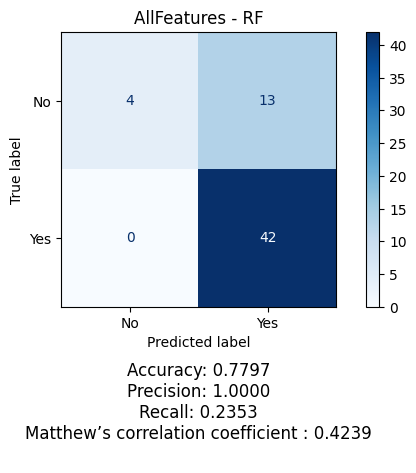

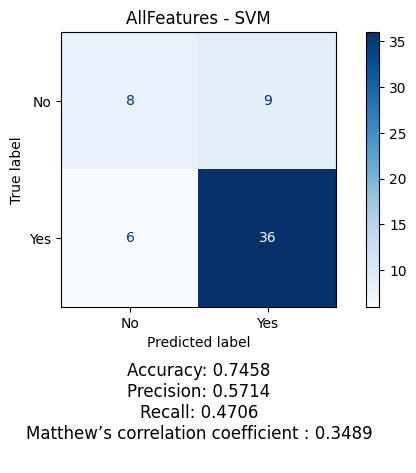

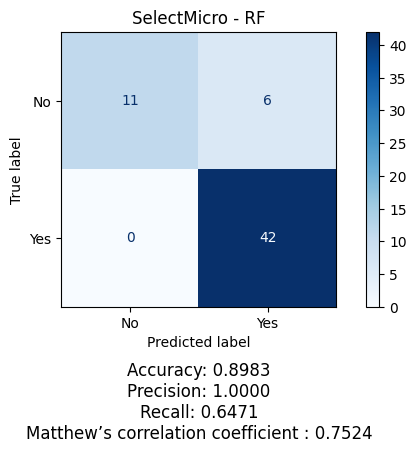

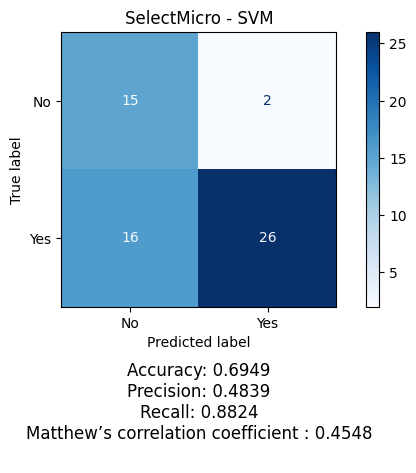

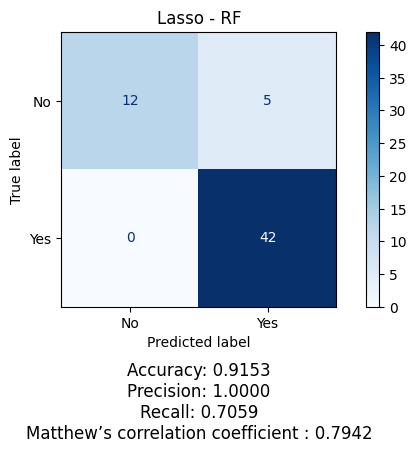

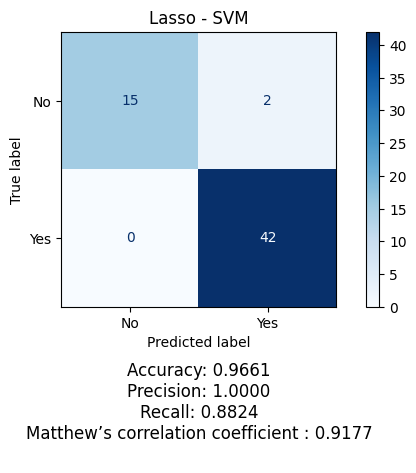

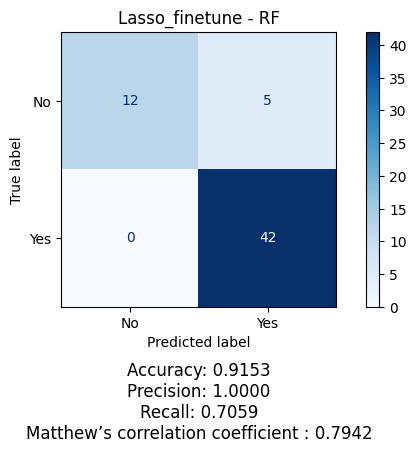

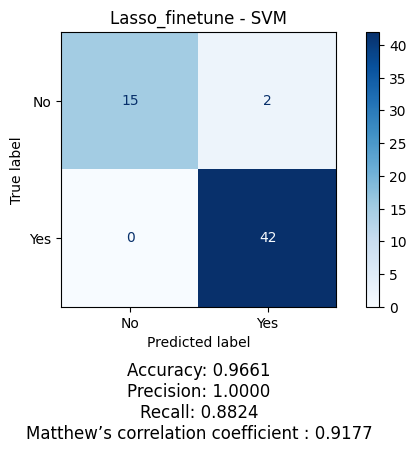

In [28]:
dict_cm = dict_cm_list[0]
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [ ]:

dict_cm = dict_cm_list[1]
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [ ]:
dict_cm = dict_cm_list[2]
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [32]:
# an update function of runAUC_FScompare- no fine tune
def runClassifier_random(data,y,Nselection,clf='RF',iteration=30,SMOTE=False):
    df = data # which is an numpy array not a df
    num_columns = df.shape[1]  # Get the number of columns in the DataFrame
    
    results = []
    random.seed(1992)
    for _ in range(iteration):
        selected_indices = random.sample(range(num_columns), Nselection)
        new_df = df[:, selected_indices]
        
        results_clf = RunML_continue.ML_model_SCV(new_df, y,clf,SMOTE=SMOTE)
        y_actual  = results_clf['y_true']
        y_pred = results_clf['y_pred']
        metric_summary_tb = metric.metric_tb(y_actual,y_pred)


        result = {"Accuracy": results_clf['mean_accuracy'],
                  "AUC":results_clf['mean_auc'],
                  "ACC": metric_summary_tb['Accuracy'],
                  "Precision": metric_summary_tb['Precision'],
                  "Recall": metric_summary_tb['Recall'],
                  "MCC": metric_summary_tb['Mcc']}
                  
        results.append(result)
    
    # Iterate over each dictionary in the list
    for result in results:
        for key, value in result.items():
            # Accumulate sums and counts for each key
            sums[key] = sums.get(key, 0) + value
            counts[key] = counts.get(key, 0) + 1

    # Calculate the averages
    average_result = {key: sums[key] / counts[key] for key in sums}

    print(average_result)
    return average_result 

In [34]:
for cl in cls:
    print(cl)
    random_result = runClassifier_random(data,yList[:,0],Nselection=56,clf=cl,iteration=30,SMOTE=True)

RF


NameError: name 'sums' is not defined

### 5. Use Leave one out Crossvalidation for fine tune the model's parameter and also the model's prediction

In [ ]:
from sklearn.model_selection import LeaveOneOut
from imblearn.over_sampling import SMOTE
def nested_loocv(X, y,classifier="SVM", smote=False):
    """
    Perform nested leave-one-out cross-validation. (loocv in parameter tuninng - inner and then loocv in testing - outer)
    suitable for small datasets like smoky data

    Parameters:
        X: ndarray
            Features.
        y: ndarray
            Labels.
        param_grid: dict
            Hyperparameter grid for tuning.
        classifier: str
            "SVM" or "RF" (Random Forest).
        smote: bool
            Whether to apply SMOTE to the training data.

    Returns:
        dict:
            Contains mean accuracy, mean AUC, and the list of metrics for each outer fold.
    """
    outer_loocv = LeaveOneOut()
    inner_loocv = LeaveOneOut()

    # Metrics to store results
    outer_accuracies = []
    #outer_aucs = []

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    for train_index, test_index in outer_loocv.split(X):
        # Outer split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply SMOTE to the training data in the outer loop
        if smote:
            sm = SMOTE(random_state=777)
            X_train, y_train = sm.fit_resample(X_train, y_train)

        # Define the classifier
        if classifier == "SVM":
            model = svm.SVC(probability=True, random_state=777)
            model_param_grid = {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf', 'linear'],
                'probability': [True]
            }
        elif classifier == "RF":
            model = RandomForestClassifier(random_state=777)
            model_param_grid = {
            'n_estimators': [200, 500],
            'max_features': ['sqrt', 'log2'],
            'max_depth' : [4,5,6,7,8],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion' :['gini', 'entropy'],
        }
        else:
            raise ValueError("Classifier must be 'SVM' or 'RF'.")

        # Inner loop for hyperparameter tuning
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=model_param_grid,
            cv=inner_loocv,
            scoring="accuracy",
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        # Get the best model
        best_model = grid_search.best_estimator_

        # Evaluate on the outer test set
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        #auc = roc_auc_score(y_test, y_prob)# not applicable since there is only one sample in the testing for LOOCV

        # Store results
        outer_accuracies.append(accuracy)
        #outer_aucs.append(auc)

        #To append the actual value (not a 1-element array), you access the first (and only) element with [0]
        y_true_all.append(y_test[0])
        y_pred_all.append(y_pred[0])
        y_prob_all.append(y_prob[0])

    # Calculate mean metrics
    mean_accuracy = sum(outer_accuracies) / len(outer_accuracies)
    #mean_auc = sum(outer_aucs) / len(outer_aucs)

    return {
        "mean_accuracy": mean_accuracy,
        #"mean_auc": mean_auc,
        "outer_accuracies": outer_accuracies,
        #"outer_aucs": outer_aucs,
        "y_true": y_true_all,
        "y_pred": y_pred_all,
        "y_prob": y_prob_all,
    }

In [ ]:
# test LOO on SelectMicro using Y0
result_testloo = nested_loocv(data_subset['SelectMicro'],yList[:,0],smote=True)

In [ ]:
print("Mean Accuracy:", result_testloo["mean_accuracy"])
print("Std Accuracy:",np.std(result_testloo["outer_accuracies"]))
metric.plot_confusion_matrices(result_testloo["y_true"], result_testloo["y_pred"],"SelectMicro-SVM_FT",pos_y=1)

In [ ]:
# test LOO on Lasso_ft using Y0
result_testloo_la = nested_loocv(data_subset['Lasso_finetune'],yList[:,0],smote=True)

In [ ]:
print("Mean Accuracy:", result_testloo_la["mean_accuracy"])
print("Std Accuracy:",np.std(result_testloo_la["outer_accuracies"]))
metric.plot_confusion_matrices(result_testloo_la["y_true"], result_testloo_la["y_pred"],title='LASSO_FT-SVM_FT',pos_y=1)


# test LOO on Lasso using Y0
result_testloo_l = nested_loocv(data_subset['Lasso'],yList[:,0],smote=True)

print("Mean Accuracy:", result_testloo_l["mean_accuracy"])
print("Std Accuracy:",np.std(result_testloo_l["outer_accuracies"]))
metric.plot_confusion_matrices(result_testloo_l["y_true"], result_testloo_l["y_pred"],title='LASSO-SVM_FT',pos_y=1)



## compare the first 20 index

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Keep only the first 20 elements

entries=20

selectedOTU_index_15_list=[arr[:entries] for arr in selectedOTU_index_list]

selectedASVs_list = []
for i in range(yList.shape[1]):
    selectedASVs = ASVs[selectedOTU_index_15_list[i]]
    selectedASVs_list.append(selectedASVs)

In [ ]:
targetLabel=burn_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[0]],yList[:,0],selectedASVs_list[0],
                     posLabel="Yes",posText="Burned",negText="Not Burned")
FS.plotPresenseRatio(X_lassoft_list[0],yList[:,0],ASVs[selectedOTU_index_lassoft_list[0]],
                     posLabel="Yes",posText="Burned",negText="Not Burned")



In [ ]:
targetLabel=un_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[1]],yList[:,1],selectedASVs_list[1],
                     posLabel="Natural",posText="Natural",negText="Urban")

FS.plotPresenseRatio(X_lassoft_list[1],yList[:,1],ASVs[selectedOTU_index_lassoft_list[1]],
                    posLabel="Natural",posText="Natural",negText="Urban")


In [ ]:
targetLabel=duration_label
FS.plotPresenseRatio(data[:,selectedOTU_index_15_list[2]],yList[:,2],selectedASVs_list[2],
                    posLabel="Annual",posText="Annual",negText="Perennial")
FS.plotPresenseRatio(X_lassoft_list[2],yList[:,2],ASVs[selectedOTU_index_lassoft_list[2]],
                    posLabel="Annual",posText="Annual",negText="Perennial")
